# Lung and Colon Cancer Classification
## About Dataset
This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.
There are five classes in the dataset, each with 5,000 images, being:

* Lung benign tissue
* Lung adenocarcinoma
* Lung squamous cell carcinoma
* Colon adenocarcinoma
* Colon benign tissue


How to Cite this Dataset
If you use in your research, please credit the author of the dataset:

Original Article
Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Relevant Links
https://arxiv.org/abs/1912.12142v1
https://github.com/tampapath/lung_colon_image_set
Dataset BibTeX
@article{,
title= {LC25000 Lung and colon histopathological image dataset},
keywords= {cancer,histopathology},
author= {Andrew A. Borkowski, Marilyn M. Bui, L. Brannon Thomas, Catherine P. Wilson, Lauren A. DeLand, Stephen M. Mastorides},
url= {https://github.com/tampapath/lung_colon_image_set}
}


## Imports

In [ ]:
import collections
import os
import random
from collections import defaultdict
from pathlib import Path

import hydra
import matplotlib.pyplot as plt
import opendatasets as od
import pandas as pd
import pyrootutils
import torch
from hydra import compose, initialize
from sklearn.model_selection import train_test_split
from torchvision import io
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

## Download datasets

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base="1.2", config_path="../configs"):
    cfg = compose(config_name="train")
    print(cfg.paths.train_raw_dir)

datasets/raw/train


In [5]:
DATASET_DIR = Path(root) / cfg.data.dataset_dir

In [6]:
DATASET_DIR.mkdir(exist_ok=True)
if len(list(DATASET_DIR.iterdir())) == 0:
    # Download the dataset
    od.download(dataset_id_or_url=cfg.data.dataset_url, data_dir=str(DATASET_DIR))

## Loading Images

In [ ]:
CLASS_NAMES = [
    "colon-adenocarcinoma",
    "colon-benign-tissue",
    "lung-adenocarcinoma",
    "lung-benign-tissue",
    "lung-squamous-cell-carcinoma",
]

class_mapping = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES, strict=False))

{0: 'colon-adenocarcinoma',
 1: 'colon-benign-tissue',
 2: 'lung-adenocarcinoma',
 3: 'lung-benign-tissue',
 4: 'lung-squamous-cell-carcinoma'}

In [ ]:
DATASET_DIR = Path(root) / cfg.data.dataset_dir / cfg.data.dataset_name

PosixPath('/home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/lung-and-colon-cancer-histopathological-images')

## Loading Images

In [9]:
datasets = ImageFolder(
    root=str(DATASET_DIR),
    transform=None,
    target_transform=None,
    is_valid_file=None,
)
print(f"Number of images in the dataset: {len(datasets)}")

Number of images in the dataset: 25000


In [ ]:
IMAGE_NUM = 9
random_range = random.sample(range(0, len(datasets)), IMAGE_NUM)

[4528, 6975, 11134, 12284, 21077, 7400, 6696, 8895, 11527]

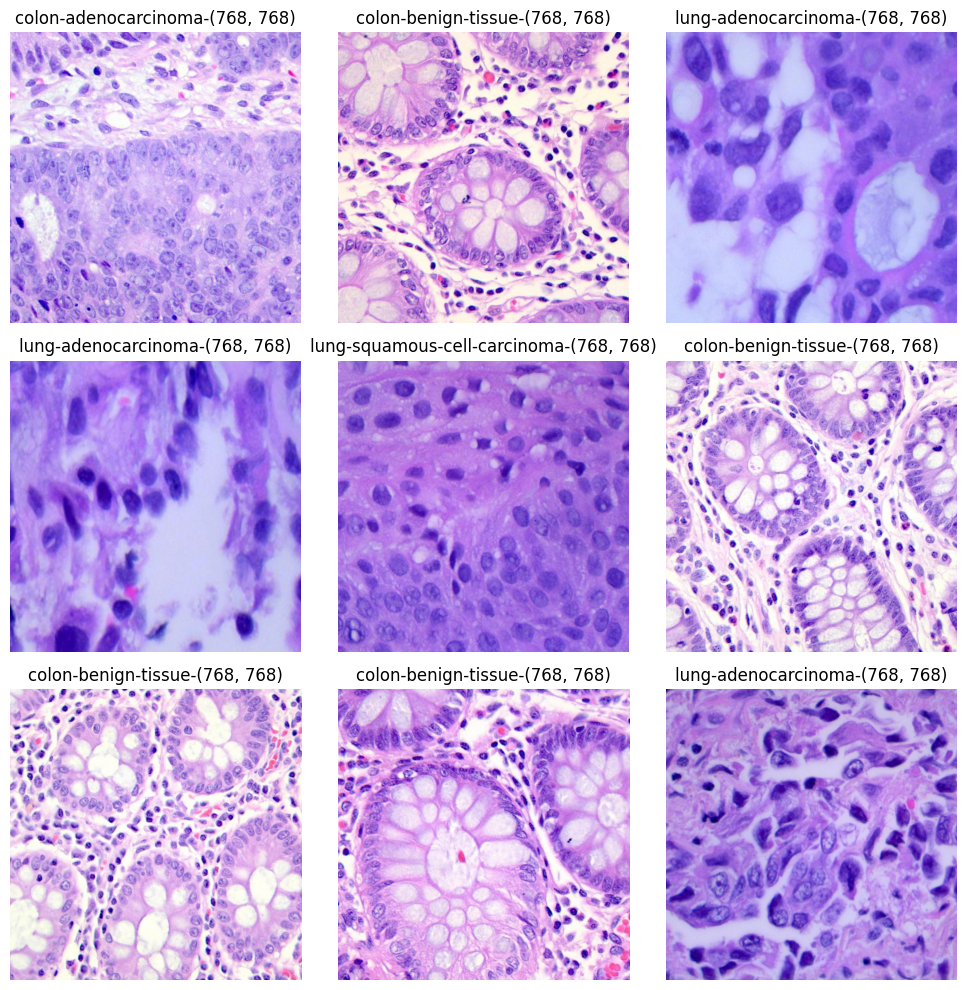

In [12]:
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    img = datasets[idx][0]
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{datasets.classes[datasets[idx][1]]}-{img.size}")  # datasets.classes[label])
plt.tight_layout()
plt.show()

In [13]:
transforms = v2.Compose(
    [
        v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomRotation(degrees=(-15, 15)),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
del datasets

In [14]:
datasets = ImageFolder(
    root=str(DATASET_DIR),
    transform=transforms,
    target_transform=None,
    is_valid_file=None,
)

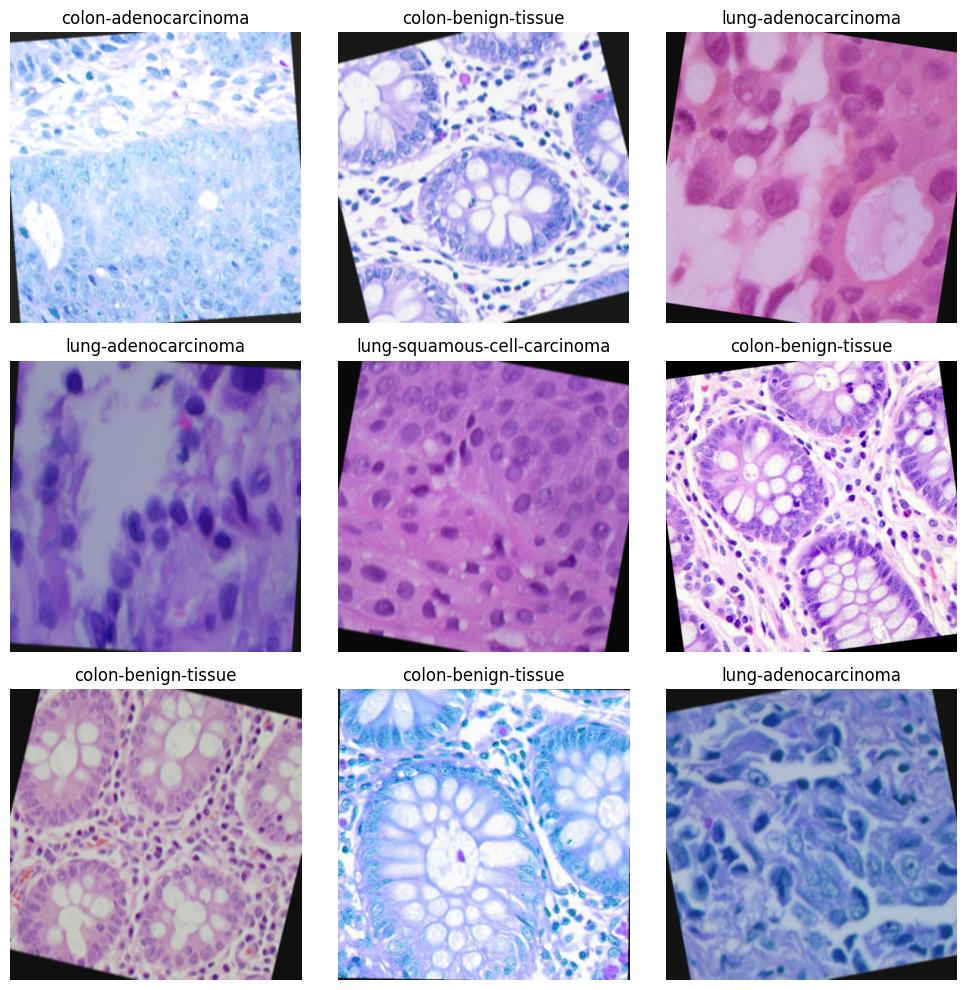

In [15]:
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    img = datasets[idx][0]
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.title(f"{datasets.classes[datasets[idx][1]]}")  # datasets.classes[label])
plt.tight_layout()
plt.show()

In [16]:
del datasets

## Train, Validatin, Split

In [17]:
class_name = []
for _dir in list(DATASET_DIR.iterdir()):
    class_name.append(_dir.name)

In [ ]:
datasets = defaultdict(list)
for class_dir_path in list(DATASET_DIR.iterdir()):
    for file_path in class_dir_path.iterdir():
        datasets[class_dir_path.name].append(file_path)

datasets["lung-squamous-cell-carcinoma"][0]

PosixPath('/home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/lung-and-colon-cancer-histopathological-images/lung-squamous-cell-carcinoma/lungscc3920.jpeg')

In [ ]:
df = pd.DataFrame(datasets)
df.head()

lung-squamous-cell-carcinoma  \
0  /home/ultron/AI/practice-projects/CV/lung-and-...   
1  /home/ultron/AI/practice-projects/CV/lung-and-...   
2  /home/ultron/AI/practice-projects/CV/lung-and-...   
3  /home/ultron/AI/practice-projects/CV/lung-and-...   
4  /home/ultron/AI/practice-projects/CV/lung-and-...   

                                  lung-benign-tissue  \
0  /home/ultron/AI/practice-projects/CV/lung-and-...   
1  /home/ultron/AI/practice-projects/CV/lung-and-...   
2  /home/ultron/AI/practice-projects/CV/lung-and-...   
3  /home/ultron/AI/practice-projects/CV/lung-and-...   
4  /home/ultron/AI/practice-projects/CV/lung-and-...   

                                 lung-adenocarcinoma  \
0  /home/ultron/AI/practice-projects/CV/lung-and-...   
1  /home/ultron/AI/practice-projects/CV/lung-and-...   
2  /home/ultron/AI/practice-projects/CV/lung-and-...   
3  /home/ultron/AI/practice-projects/CV/lung-and-...   
4  /home/ultron/AI/practice-projects/CV/lung-and-...   

                                 colon-benign-tissue  \
0  /home/ultron/AI/practice-projects/CV/lung-and-...   
1  /home/ultron/AI/practice-projects/CV/lung-and-...   
2  /home/ultron/AI/practice-projects/CV/lung-and-...   
3  /home/ultron/AI/practice-projects/CV/lung-and-...   
4  /home/ultron/AI/practice-projects/CV/lung-and-...   

                                colon-adenocarcinoma  
0  /home/ultron/AI/practice-projects/CV/lung-and-...  
1  /home/ultron/AI/practice-projects/CV/lung-and-...  
2  /home/ultron/AI/practice-projects/CV/lung-and-...  
3  /home/ultron/AI/practice-projects/CV/lung-and-...  
4  /home/ultron/AI/practice-projects/CV/lung-and-...

In [ ]:
train_ds, test_ds = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
)
train_ds, val_ds = train_test_split(
    train_ds,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [22]:
def create_dataset_dir(dataset_split_dir: Path, dataset_df: pd.DataFrame) -> None:
    dataset_split_dir.mkdir(parents=True, exist_ok=True)
    for dir_name in dataset_df.columns:
        os.makedirs(dataset_split_dir / dir_name, exist_ok=True)
        for file_path in dataset_df[dir_name]:
            file_name = file_path.name
            new_file_path = dataset_split_dir / dir_name / file_name
            if not new_file_path.exists():
                os.symlink(file_path, new_file_path)

In [23]:
train_raw_dir = Path(root) / cfg.paths.train_raw_dir
# create_dataset_dir(dataset_split_dir=train_raw_dir, dataset_df=train_ds)
# valid_raw_dir = Path(root) / cfg.paths.valid_raw_dir
# create_dataset_dir(dataset_split_dir=valid_raw_dir, dataset_df=val_ds)

# test_raw_dir = Path(root) / cfg.paths.test_raw_dir
# create_dataset_dir(dataset_split_dir=test_raw_dir, dataset_df=test_ds)

## Resize and save processed image

In [28]:
train_transforms = hydra.utils.instantiate(cfg.data.train_preprocess_transforms)

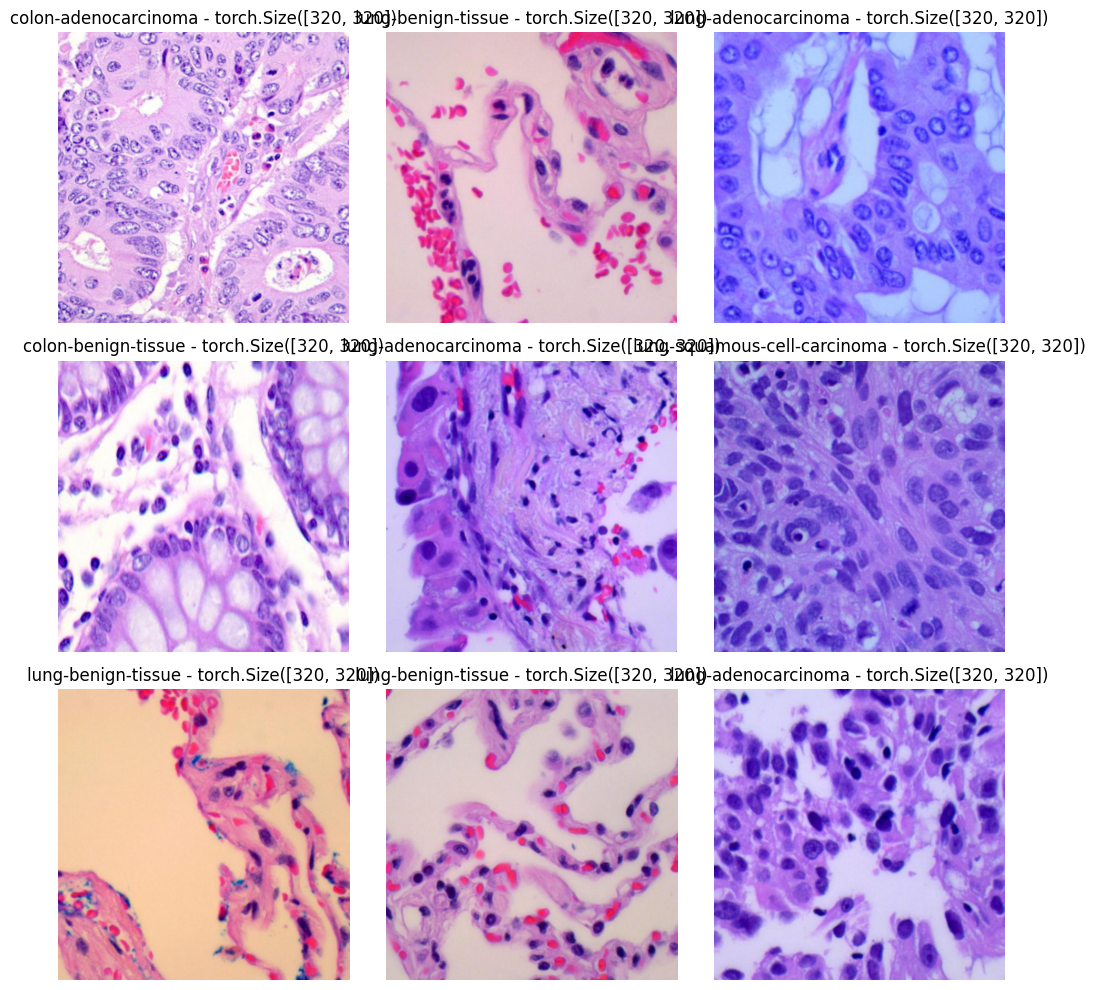

In [29]:
transforms = v2.Compose(train_transforms)

train_dataset = ImageFolder(
    root=str(train_raw_dir),
    transform=transforms,
    target_transform=None,
    is_valid_file=None,
)

plt.figure(figsize=(10, 10))
IMAGE_NUM = 9
random_range = random.sample(range(0, len(train_dataset)), IMAGE_NUM)

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    img = train_dataset[idx][0]
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.title(f"{train_dataset.classes[train_dataset[idx][1]]} - {img.size()[-2:]}")  # datasets.classes[label])
plt.tight_layout()
plt.show()

In [30]:
# Register a resolver for torch dtypes
# from omegaconf import OmegaConf


# OmegaConf.register_new_resolver("torch_dtype", lambda name: getattr(torch, name))

In [ ]:
valid_transforms = hydra.utils.instantiate(cfg.data.valid_preprocess_transforms)
transforms = v2.Compose(valid_transforms)
valid_raw_dir = Path(root) / cfg.paths.valid_raw_dir
valid_dataset = ImageFolder(
    root=str(valid_raw_dir),
    transform=transforms,
    target_transform=None,
    is_valid_file=None,
)

In [ ]:
def save_images_from_datasets(img_save_path: Path, dataset: ImageFolder):
    class_image_counters = collections.defaultdict(int)

    img_save_path.mkdir(parents=True, exist_ok=True)
    for image_data_tuple in dataset:
        img = image_data_tuple[0]
        label = dataset.classes[image_data_tuple[1]]
        print(f"Label: {label}, Image size: {img.size()[-2:]}")

        current_count = class_image_counters[label]

        img_path = img_save_path / label
        print(f"Image path: {img_path}")
        img_path.mkdir(parents=True, exist_ok=True)
        io.write_jpeg(input=img, filename=str(img_path / f"{label}_{current_count}.jpeg"), quality=100)
        class_image_counters[label] += 1


img_save_path = Path(root) / cfg.paths.valid_processed_dir
save_images_from_datasets(img_save_path=img_save_path, dataset=valid_dataset)

Label: colon-adenocarcinoma, Image size: torch.Size([320, 320])
Image path: /home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/processed/valid/colon-adenocarcinoma
Label: colon-adenocarcinoma, Image size: torch.Size([320, 320])
Image path: /home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/processed/valid/colon-adenocarcinoma
Label: colon-adenocarcinoma, Image size: torch.Size([320, 320])
Image path: /home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/processed/valid/colon-adenocarcinoma
Label: colon-adenocarcinoma, Image size: torch.Size([320, 320])
Image path: /home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/processed/valid/colon-adenocarcinoma
Label: colon-adenocarcinoma, Image size: torch.Size([320, 320])
Image path: /home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/datasets/processed/valid/c